<a href="https://colab.research.google.com/github/mtajilrou/whaly/blob/master/Humback_Wales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import absolute_import, division, print_function

import os
import csv
from shutil import copyfile

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.13.1


##Install Kaggle API and make a directory called kaggle


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

##import API into colab

In [6]:

!rm kaggle.json
from google.colab import files
files.upload()

rm: cannot remove 'kaggle.json': No such file or directory


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mtajilrou","key":"d891a7d0473961f2fca7bce9b8e36212"}'}

##copy API key to kaggle directory

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##Download the dataset

In [8]:
!kaggle competitions download -c humpback-whale-identification

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 67.9MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 39.3MB/s]
100% 1.34G/1.35G [00:29<00:00, 40.0MB/s]
100% 1.35G/1.35G [00:29<00:00, 49.4MB/s]
100% 4.15G/4.16G [01:41<00:00, 51.6MB/s]
100% 4.16G/4.16G [01:41<00:00, 43.8MB/s]


##unzip the downloaded data file

In [0]:
import zipfile

full_train_dir = "/content/whales/train/"


zip_ref = zipfile.ZipFile("/content/train.zip","r")
zip_ref.extractall(path=full_train_dir)
zip_ref.close()


Extract a subset of the training data for the 31 whales that have the most number of samples

In [0]:
train_dir_path ="/content/train_new"
validation_dir_path ="/content/test_new"

myids = ['w_23a388d',
'w_9b5109b',
'w_9c506f6',
'w_0369a5c',
'w_700ebb4',
'w_3de579a',
'w_564a34b',
'w_fd3e556',
'w_88e4537',
'w_2b069ba',
'w_d405854',
'w_789c969',
'w_f0fe284',
'w_343f088',
'w_5e8e218',
'w_778e474',
'w_5a2634c',
'w_60ce6fc',
'w_a9304b9',
'w_6822dbc',
'w_af367c3',
'w_1ca9ab1',
'w_f765256',
'w_17b0d3a',
'w_d72771c',
'w_08630fd',
'w_6cda039',
'w_8c25681',
'w_04003e9',
'w_51fc1fc',
'w_fd6a3ad']



if not os.path.exists(train_dir_path):
  os.mkdir(train_dir_path)

if not os.path.exists(validation_dir_path):
  os.mkdir(validation_dir_path)

for wid in myids:
    # create a folder for this whale in the training set
    path = os.path.join(train_dir_path,wid)
    if not os.path.exists(path):
      os.mkdir(path)

    # create a folder for this whale in the test set
    path = os.path.join(validation_dir_path,wid)
    if not os.path.exists(path):
      os.mkdir(path)

In [0]:
valid_files = {}

with open('/content/train.csv', 'r') as f:
    reader= csv.reader(f)
    for row in reader:
        if row[1] in myids:
            if not row[1] in valid_files:
              valid_files[row[1]] = 0
              
            if valid_files[row[1]] >= 6:
              src = os.path.join(full_train_dir, row[0])
              dst = os.path.join(train_dir_path,row[1], row[0])

              copyfile(src, dst)
              
            else:
              src = os.path.join(full_train_dir, row[0])
              dst = os.path.join(validation_dir_path,row[1], row[0])
            
              copyfile(src, dst)
              
              valid_files[row[1]] += 1
            

# Now, Let's do the training

In [12]:
image_size = 160 # All images will be resized to 160x160
batch_size = 64

train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir_path,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                validation_dir_path, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 1139 images belonging to 31 classes.
Found 186 images belonging to 31 classes.


## Get a base model

In [13]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0]

## Create a new model using the base model

In [14]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(myids)*2, activation='relu'),
  keras.layers.Dense(len(myids), activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 62)                79422     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                1953      
Total params: 2,339,359
Trainable params: 81,375
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

In [15]:
epochs = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
18/18 [==============================] - 20s 1s/step - loss: 3.2592 - acc: 0.1212 - val_loss: 3.2497 - val_acc: 0.0753
Epoch 2/20
18/18 [==============================] - 13s 745ms/step - loss: 2.6623 - acc: 0.2871 - val_loss: 3.1239 - val_acc: 0.1344
Epoch 3/20
18/18 [==============================] - 15s 848ms/step - loss: 1.9593 - acc: 0.4820 - val_loss: 2.9690 - val_acc: 0.1505
Epoch 4/20
18/18 [==============================] - 14s 770ms/step - loss: 1.4329 - acc: 0.6348 - val_loss: 3.1256 - val_acc: 0.1774
Epoch 5/20
18/18 [==============================] - 15s 851ms/step - loss: 1.1179 - acc: 0.7331 - val_loss: 2.7891 - val_acc: 0.2366
Epoch 6/20
18/18 [==============================] - 15s 856ms/step - loss: 0.8517 - acc: 0.8183 - val_loss: 2.7314 - val_acc: 0.2527
Epoch 7/20
18/18 [==============================] - 15s 854ms/step - loss: 0.7051 - acc: 0.8586 - val_loss: 2.9463 - val_acc: 0.1667
Epoch 8/20
18/18 [======

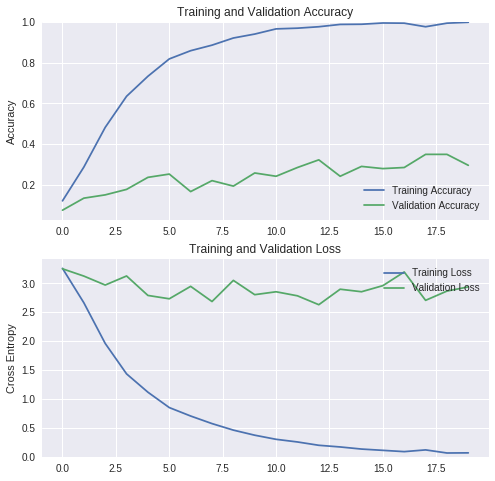

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()